<a href="https://colab.research.google.com/github/OVP2023/NN/blob/main/DZ3_%D0%A3%D0%BB%D1%83%D1%87%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''Домашнее задание к занятию «Улучшение качества обучения нейросети»

Цель задания: научиться использовать в коде различные методы Transfer Learning.

Задание:
На примере датасета персонажей мультфильма Симпсонов:

    Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.
    Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.
    Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.
    Оформите вывод по результатам проведённых экспериментов.
'''

'Домашнее задание к занятию «Улучшение качества обучения нейросети»\n\nЦель задания: научиться использовать в коде различные методы Transfer Learning.\n\nЗадание:\nНа примере датасета персонажей мультфильма Симпсонов:\n\n    Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.\n    Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.\n    Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.\n    Оформите вывод по результатам проведённых экспериментов.\n'

In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "/content/drive/MyDrive/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 2186
Изображений в val: 938


In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  6
Количество классов в val:  6
Количество классов одинаково:  True


In [ ]:
#Посмотрим на изображения из val и train
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(18, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=5)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

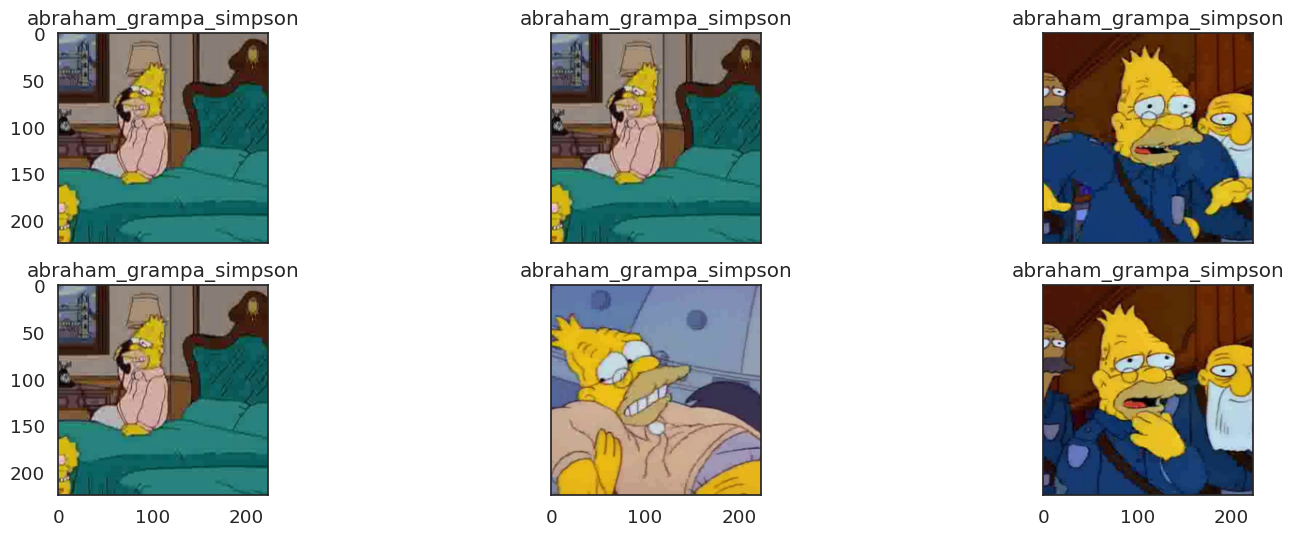

In [ ]:
show_images(val_dataset)

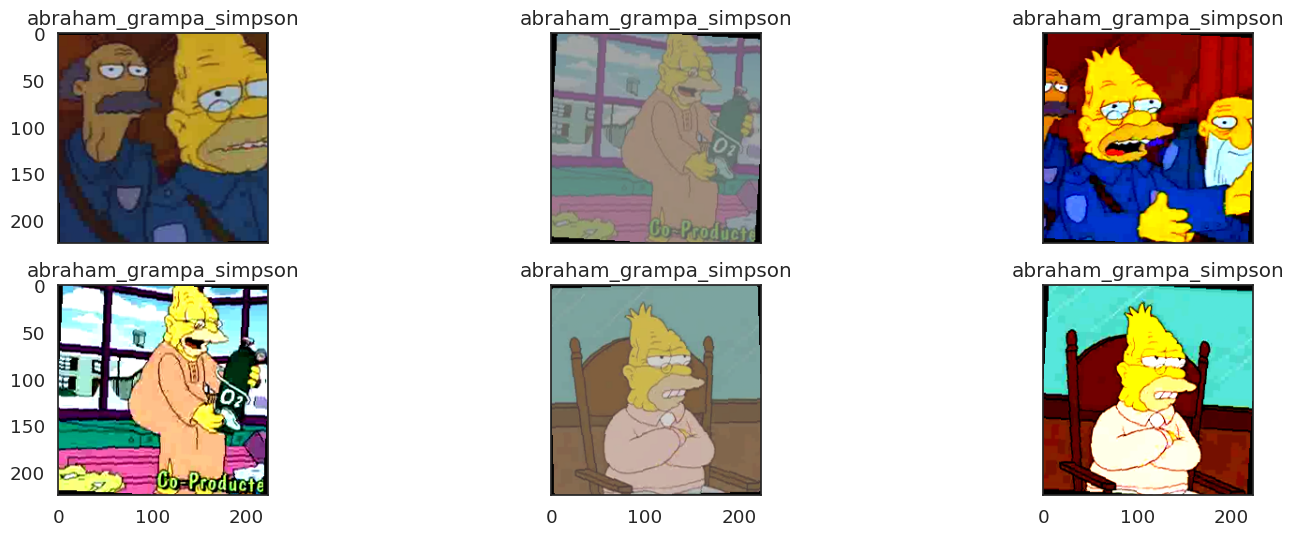

In [ ]:
show_images(train_dataset)

In [ ]:
'''Невооруженным взглядом видно, что картинки из train выглядят немного изменёнными по сравнению с val. Опишем по пунктам, почему так происходит.

    К train применялись дополнительные аугментации ColorJitter и RandomAffine, чтобы увеличить размер датасета и обобщающую способность сети.
    К val никакие меняющие изображение аугментации не применялись, т.к. замерять метрику качества необходимо на настоящих данных.'''

'Невооруженным взглядом видно, что картинки из train выглядят немного изменёнными по сравнению с val. Опишем по пунктам, почему так происходит.\n\n    К train применялись дополнительные аугментации ColorJitter и RandomAffine, чтобы увеличить размер датасета и обобщающую способность сети.\n    К val никакие меняющие изображение аугментации не применялись, т.к. замерять метрику качества необходимо на настоящих данных.'

In [ ]:
#Создадим DataLoader-ы и функции для обучения

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [20]:
from torchvision.models import mobilenet_v3_small

In [ ]:
#Обучим mobilenet_v3_small с нуля

Epoch 10 of 10 took 125.741s
  training loss (in-iteration): 	1.615214
  validation loss (in-iteration): 	4.638170
  training accuracy: 			42.88 %
  validation accuracy: 			42.69 %


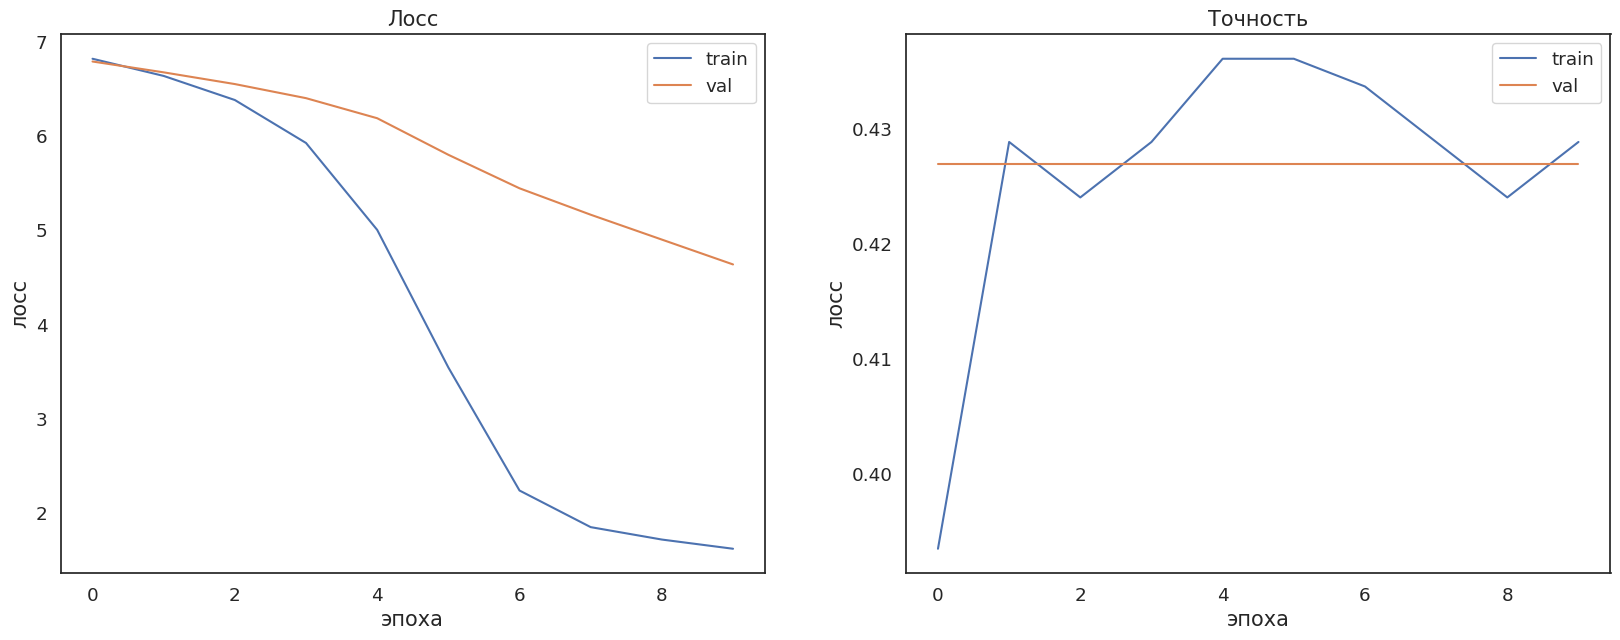

In [ ]:
model = mobilenet_v3_small(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Epoch 10 of 10 took 27.933s
  training loss (in-iteration): 	0.559414
  validation loss (in-iteration): 	0.442308
  training accuracy: 			83.13 %
  validation accuracy: 			87.60 %


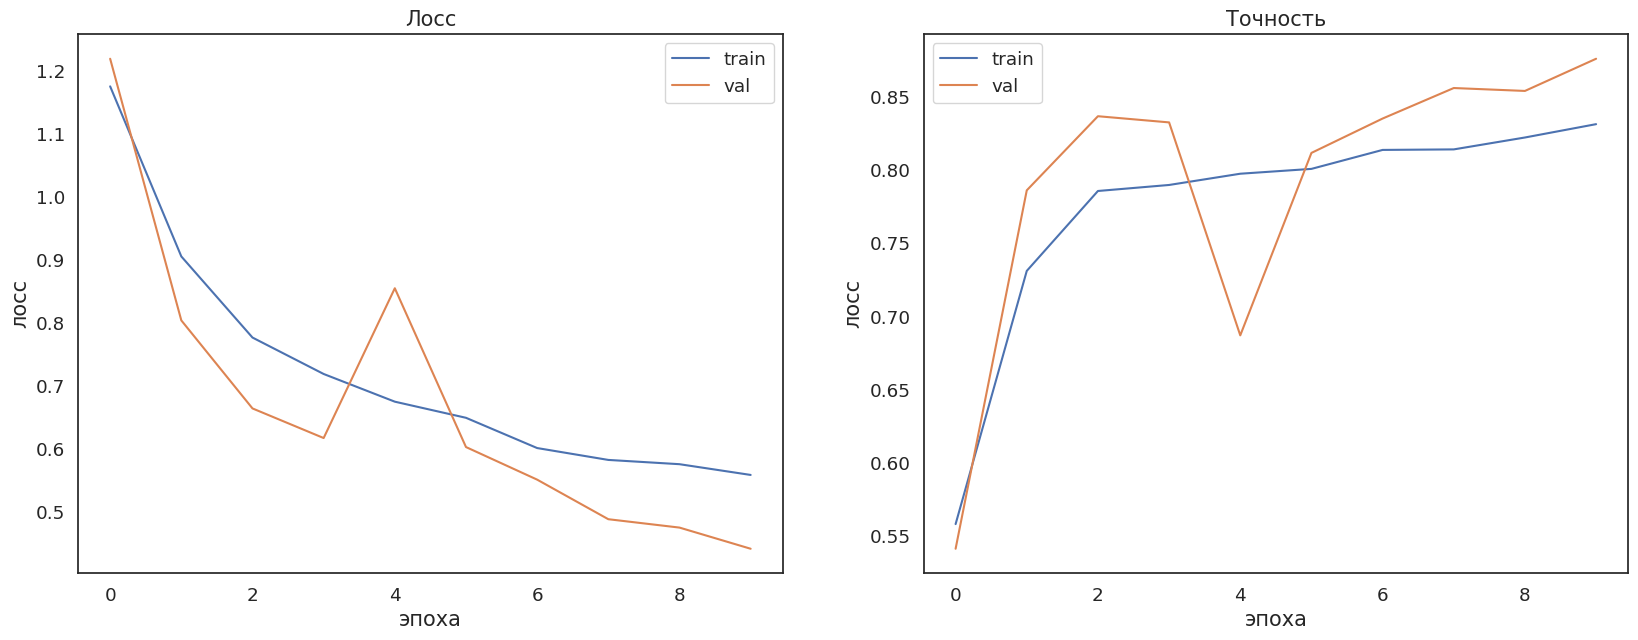

In [21]:
#Будем использовать сеть как Feature Extractor
# возьмём предобученную сеть

from torchvision.models import resnet18

fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 6)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Epoch 10 of 10 took 39.648s
  training loss (in-iteration): 	0.654056
  validation loss (in-iteration): 	0.517712
  training accuracy: 			77.38 %
  validation accuracy: 			82.46 %


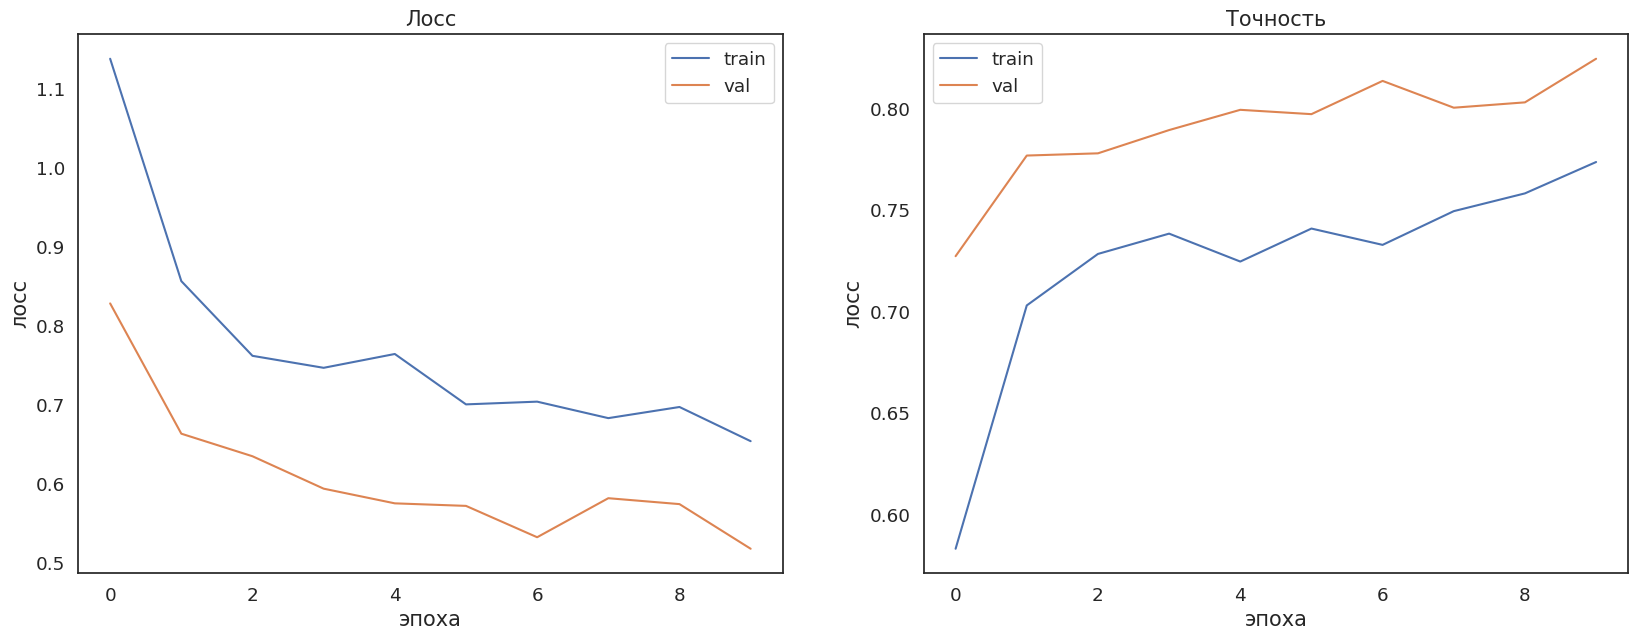

In [29]:

from torchvision.models import vgg16

fe_model = vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
classifier_list = list(fe_model.classifier.children())
classifier_list.pop()
classifier_list.append(nn.Linear(4096,6))
fe_model.classifier = nn.Sequential(*classifier_list)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fe_model.parameters(), lr=0.001)


fe_model = fe_model.to(device)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Epoch 10 of 10 took 27.496s
  training loss (in-iteration): 	0.193709
  validation loss (in-iteration): 	0.200772
  training accuracy: 			94.18 %
  validation accuracy: 			93.02 %


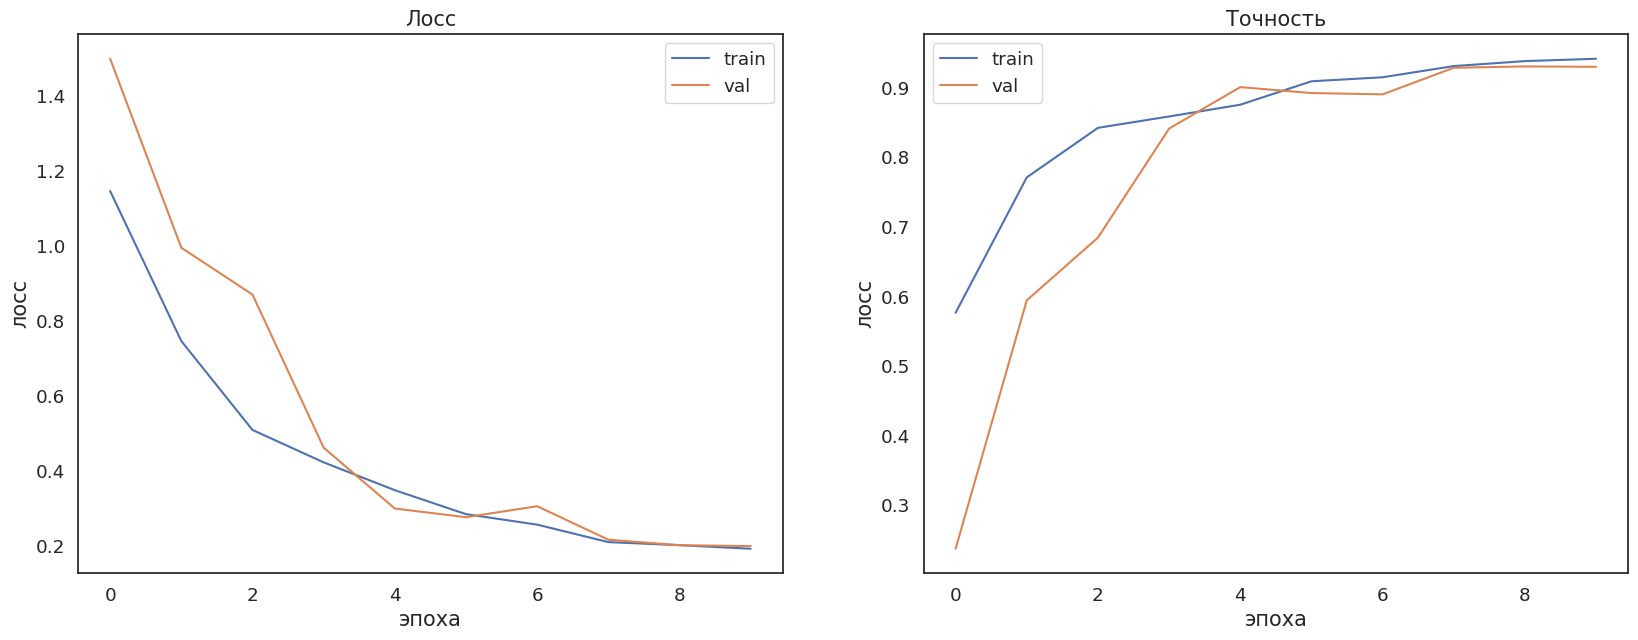

In [ ]:
#Будем использовать fine_tuning
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet', mobilenet_v3_small(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 6))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Epoch 10 of 10 took 60.220s
  training loss (in-iteration): 	0.129810
  validation loss (in-iteration): 	0.145026
  training accuracy: 			95.89 %
  validation accuracy: 			95.81 %


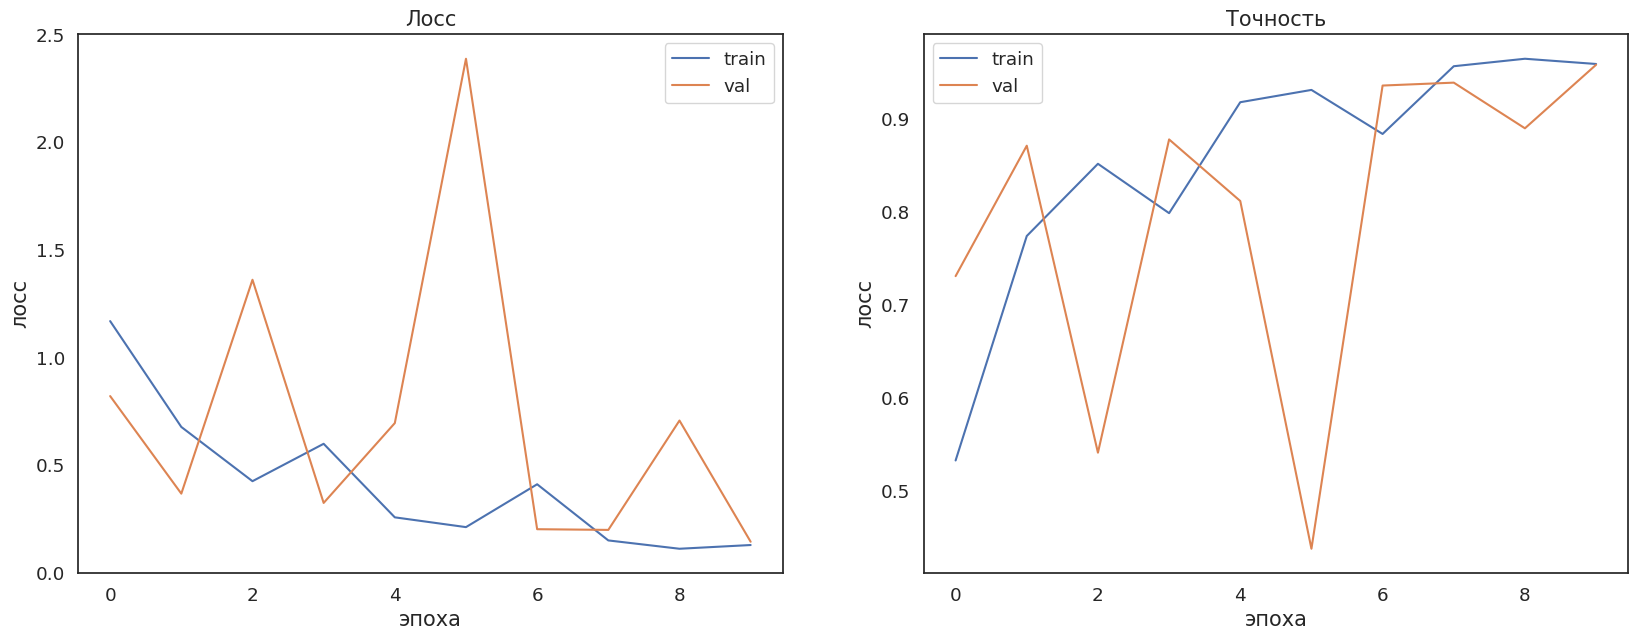

In [30]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('vgg16', vgg16(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 6))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

In [ ]:
''' Вывод: Лучшие результаты validation accuracy и loss  достигаются при fine tuning (validation accuracy: 			95.81 %), т.к. классы simpson отличаются от классов IMAGENET,
которые использовались при первоначальном обучении моделей и были заморожены при Feature Extractor (  validation accuracy: 			82.46 %)'''